<center><img src="http://mdst.eecs.umich.edu/images/mdst-logo-circle.png" width=350></center>

# Introduction to Decision Trees

Decision trees make excellent classifiers.  They are able to capture more complicated structure than linear models and a trained decision tree has an easy interpretation.

A decision tree makes predictions by partitioning the input space, or the space that our data lives in, into regions and then assigning a label to each region.

How does the decision tree decide where to split?  And how does it know which dimension to split on first?  These decisions will be determined by the mathematical formulation of the model, and we will omit them here.  If you are interested in learning more, see <a href="https://en.wikipedia.org/wiki/Decision_tree_learning">this wikipedia article</a>.  To specifically learn about how decision trees split the input space into regions, read the section titled "Metrics."

That said, let's take a look at using these things.

In [1]:
# We begin by importing numpy and pandas, as usual.
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# We'll be evaluating our models as well.
from sklearn.metrics import roc_auc_score as roc
from sklearn.metrics import roc_curve

In [2]:
# Read the dataset
# NOTE: you will have to copy the data into this directory manually.
df = pd.read_excel('./data/UM_field_hockey_Catapult_deidentified_17_01_18.xlsx')
df.head()

,Player Name,Period Name,Activity Name,Period Number,Date,Start Time,End Time,Day Name,Month Name,Total Distance,...,IMA Accel High,IMA Decel Low,IMA Decel Medium,IMA Decel High,IMA CoD Left Low,IMA CoD Left Medium,IMA CoD Left High,IMA CoD Right Low,IMA CoD Right Medium,IMA CoD Right High
0,Sarah Smith,Session,AM Practice 8-11-16,0,2016-08-11,07:00:29,10:01:00,Thursday,August,10070.88693,...,28,26,3,1,114,34.0,8.0,182.0,26.0,2.0
1,Ronda Buckman,Session,AM Practice 8-11-17,0,2016-08-11,07:00:29,10:01:00,Thursday,August,9186.53032,...,7,31,2,3,105,17.0,12.0,92.0,8.0,8.0
2,Kylie Burke,Session,AM Practice 8-11-18,0,2016-08-11,07:00:29,10:01:00,Thursday,August,8728.42473,...,13,10,5,1,91,18.0,8.0,124.0,15.0,10.0
3,Emma Wohlman,Session,AM Practice 8-11-19,0,2016-08-11,07:00:29,10:01:00,Thursday,August,9758.65793,...,14,29,2,0,114,37.0,8.0,96.0,7.0,4.0
4,Monica Westover,Session,AM Practice 8-11-20,0,2016-08-11,07:00:29,10:01:00,Thursday,August,9345.81531,...,12,47,10,4,116,35.0,16.0,96.0,15.0,1.0


We're going to use decision trees to **predict the activity type** from the **acceleration and force data**. This is just one example of what you could predict. Decision trees can be used for regression as well as classification - so you could also predict the total distance from the forces, for example.

We're going to split the **activity type** into two categories: (0) practices and (1) games. If we take a look at the different activity types (column `Activity Name`), we can see which periods correspond to practices and which correspond to games.

In [3]:
df['Activity Name'].head()

0    AM Practice 8-11-16
1    AM Practice 8-11-17
2    AM Practice 8-11-18
3    AM Practice 8-11-19
4    AM Practice 8-11-20
Name: Activity Name, dtype: object

In [4]:
# Do some simple cleaning to filter out practices, workouts, and other activities

def is_practice(x):
    if x.find('Practice')>=0: return True
    elif x.find('Activity')>=0: return True
    elif x.find('Workouts')>=0: return True
    elif x.find('Run')>=0: return True
    else: return False

# This function now tells you what activities are practices. We can apply it to each row.
df['is_practice'] = df['Activity Name'].apply(is_practice)

# This gives us a list of all the games
df['Activity Name'].loc[np.logical_not(df.is_practice)].value_counts()

MSU Scrimmage 8-20-16        75
MSU 11-3-16                  75
UNC 8-27-16                  75
Iowa 10-16-16                75
Maryland 9-30-16             75
Northwestern 10-21-16        73
Indiana 10-14-16             60
Stanford 9-2-16              60
Cal 9-4-16                   60
PSU 9-25-16                  60
Louisville 10-29-16          60
PSU 11-4-16                  60
Villanova 9-10-16            60
UVA 11-12-16                 60
Toronto Scrimmage 8-21-16    60
UNC 10-2-16                  60
Ohio State 9-23-16           58
Rutgers 10-7-16              57
Wake Forest 8-28-16          56
Delaware 10-8-16             56
MSU - 9-16-16                52
CMU - 9-18-16                48
Name: Activity Name, dtype: int64

In [5]:
# Now, we construct the dataset for our decision tree experiment

# We use these columns to predict
predictor_columns = ['Total Distance',
       'High Speed Distance', 'Velocity Band 1 Total Distance',
       'Velocity Band 2 Total Distance', 'Velocity Band 3 Total Distance',
       'Velocity Band 4 Total Distance', 'Velocity Band 5 Total Distance',
       'Meterage Per Minute', 'Maximum Velocity', 'Total Player Load',
       'Player Load Per Minute', 'Tot IMA', 'High IMA', 'IMA Accel Low',
       'IMA Accel Medium', 'IMA Accel High', 'IMA Decel Low',
       'IMA Decel Medium', 'IMA Decel High', 'IMA CoD Left Low',
       'IMA CoD Left Medium', 'IMA CoD Left High', 'IMA CoD Right Low',
       'IMA CoD Right Medium', 'IMA CoD Right High']

# And this column is our target
target_column = ['is_practice']

X = df[predictor_columns]
Y = df[target_column]

X = X.fillna(0)

Now, we split into a training and test set. We can just do this randomly.

In [6]:
# Note: this function is deprecated and will throw a warning. But it still works.
from sklearn.cross_validation import train_test_split

Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y)

print('Number of training samples:', len(Xtrain))
print('Number of test samples:', len(Xtest))

Number of training samples: 5186
Number of test samples: 1729


/usr/local/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


There are several different classifiers in sklearn that depend on decision trees.  We will start with the simplest one, a single tree classifier.  These become the building blocks of more complicated models.

In [7]:
from sklearn.tree import DecisionTreeClassifier

# Declare the classifier with default options
dt = DecisionTreeClassifier()

# Fit on training data
dt.fit(Xtrain, Ytrain)

# Wow that's pretty easy
yhat1 = dt.predict_proba(Xtest)

Let's check how our model performed. We will measure performance using AUROC.

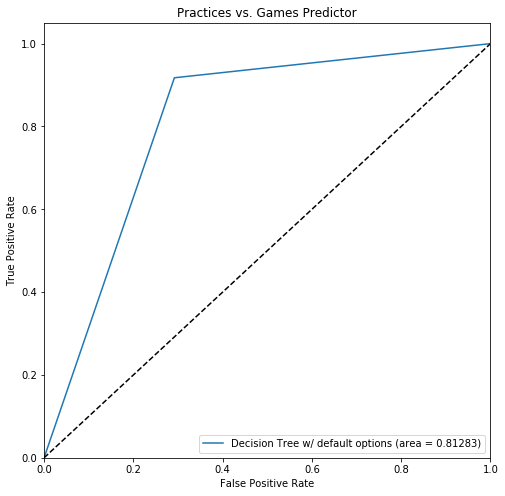

In [8]:
fig = plt.figure()
fig.set_size_inches(8,8)

fpr, tpr, _ = roc_curve(Ytest, yhat1[:,1])
plt.plot(fpr, tpr, label= 'Decision Tree w/ default options (area = %0.5f)' % roc(Ytest, yhat1[:,1]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Practices vs. Games Predictor')
plt.legend(loc="lower right")

plt.show()

Why is there only one point on the graph? It's because our model always predicts that a particular data point is true or false with 100% certainty. By default, the decision tree grows until it makes 0 mistakes on the training set. This means that each "leaf" of the tree will contain 100% false examples or 100% true examples.

If we make our decision tree "shallower", it will make some mistakes on the training set but do better on the test set.

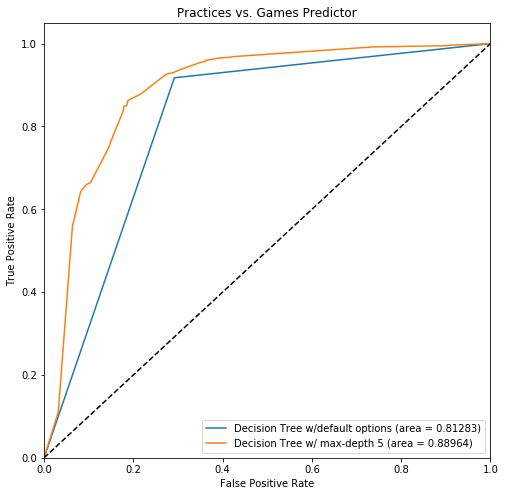

In [9]:
# Set the max depth to 5 (previous: unlimited)
dt_shallow = DecisionTreeClassifier(max_depth=7)

# Fit on training data
dt_shallow.fit(Xtrain, Ytrain)
yhat1_shallow = dt_shallow.predict_proba(Xtest)

fig = plt.figure()
fig.set_size_inches(8,8)

fpr_shallow, tpr_shallow, _ = roc_curve(Ytest, yhat1_shallow[:,1])
plt.plot(fpr, tpr, label= 'Decision Tree w/default options (area = %0.5f)' % roc(Ytest, yhat1[:,1]))
plt.plot(fpr_shallow, tpr_shallow, label= 'Decision Tree w/ max-depth 5 (area = %0.5f)' % roc(Ytest, yhat1_shallow[:,1]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Practices vs. Games Predictor')
plt.legend(loc="lower right")

plt.show()

Ok cool, but what does our decision tree actually look like? Turns out we can draw it.

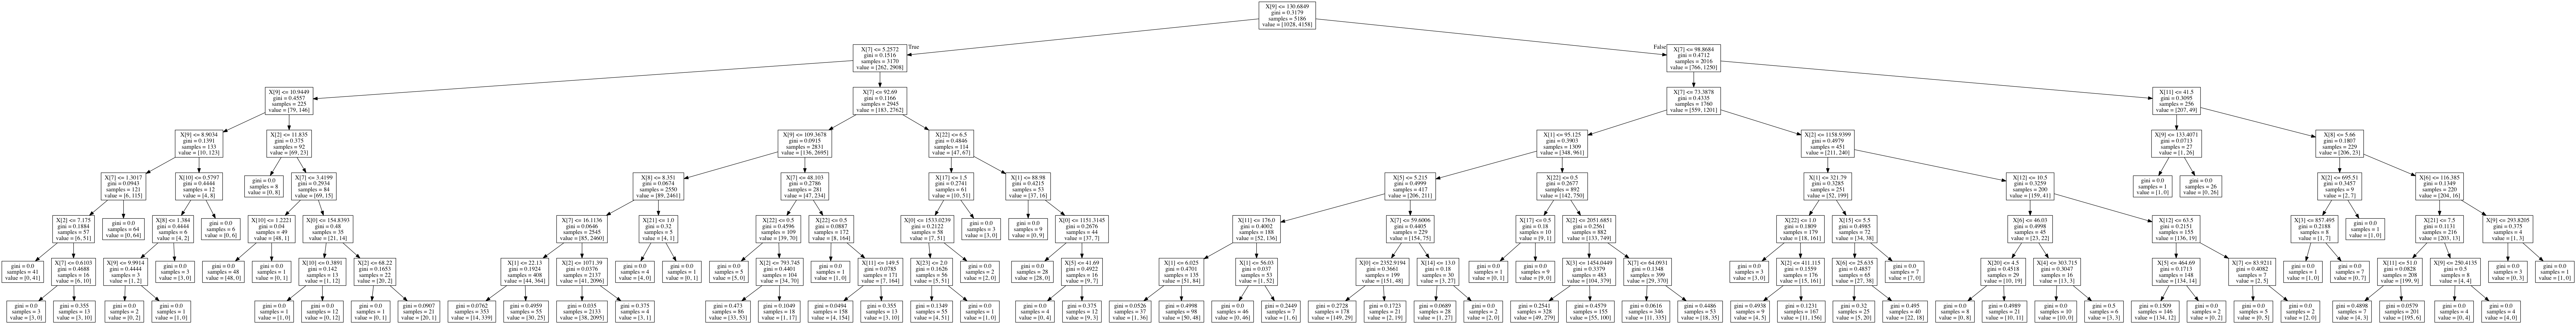

In [10]:
import sklearn.tree

sklearn.tree.export_graphviz(dt_shallow, out_file='dt.dot')

# You'll have to do this next part manually outside of the Jupyter notebook. Instructions for mac:

# brew install graphviz
# dot -Tpng dt.dot -o dt.png

from IPython.display import Image
Image("dt.png")

Random forest classifiers are excellent.  They are cheap to run, they are parallelizable, and the produce very good results.  They are a good go-to first classifier when you get a new data set.

Random forests are collections of decision trees.  Each tree learns on a different subset of the columns in the data space.  Once all the trees are learned, the model combines the predictions into a better classifer.  How????

This will help you get a little bit of intuition.  Suppose that we had 4 models that were independent of each other.  The models make a correct prediction with the following probabilities:

<pre>

|       | Probability Correct | Probability Incorrect |
|-------|---------------------|-----------------------|
|Model 1|       0.70          |         0.30          |
|Model 2|       0.65          |         0.35          |
|Model 3|       0.60          |         0.40          |
|Model 4|       0.55          |         0.45          |
|-------|---------------------|-----------------------|

</pre>

What is the probability that Model 1 makes an incorrect prediction while model 2, 3 and 4 make a correct prediction?

In [11]:
0.3*0.65*0.6*0.5, 0.7*0.35*0.4*0.45

(0.058499999999999996, 0.04409999999999999)

In [12]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=1024, n_jobs=-1)
rf.fit(Xtrain, Ytrain)
yhat_forest = rf.predict_proba(Xtest)

/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


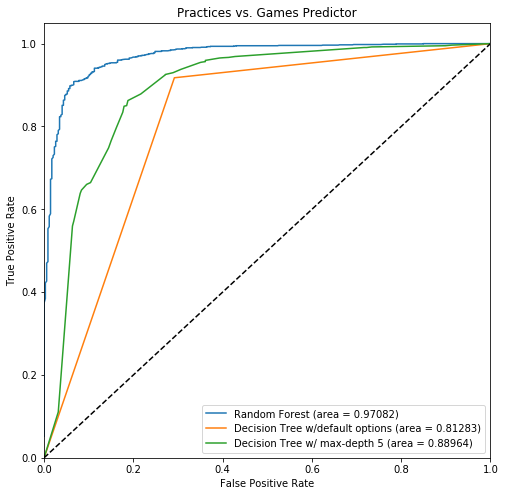

In [13]:
fig = plt.figure()
fig.set_size_inches(8,8)

fpr_forest, tpr_forest, _ = roc_curve(Ytest, yhat_forest[:,1])
plt.plot(fpr_forest, tpr_forest, label= 'Random Forest (area = %0.5f)' % roc(Ytest, yhat_forest[:,1]))
plt.plot(fpr, tpr, label= 'Decision Tree w/default options (area = %0.5f)' % roc(Ytest, yhat1[:,1]))
plt.plot(fpr_shallow, tpr_shallow, label= 'Decision Tree w/ max-depth 5 (area = %0.5f)' % roc(Ytest, yhat1_shallow[:,1]))


plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Practices vs. Games Predictor')
plt.legend(loc="lower right")

plt.show()

ExtraTreesClassifier is like a random forest, only EXTRA RANDOM!  This model is called an extremely randomized trees model.  This model acts like a random forest, except instead of training the individual decision trees the usual way by  trying to split the input space optimally it splits the input space randomly.  Hence "Extremely Random"

In [14]:
from sklearn.ensemble import ExtraTreesClassifier

et = ExtraTreesClassifier(n_estimators=4096, n_jobs=-1)
et.fit(Xtrain, Ytrain)
yhat_et = et.predict_proba(Xtest)

/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


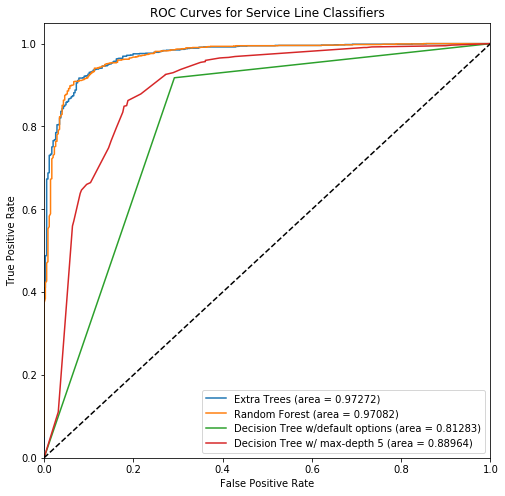

In [15]:
fig = plt.figure()
fig.set_size_inches(8,8)

fpr_et, tpr_et, _ = roc_curve(Ytest, yhat_et[:,1])
plt.plot(fpr_et, tpr_et, label= 'Extra Trees (area = %0.5f)' % roc(Ytest, yhat_et[:,1]))
plt.plot(fpr_forest, tpr_forest, label= 'Random Forest (area = %0.5f)' % roc(Ytest, yhat_forest[:,1]))
plt.plot(fpr, tpr, label= 'Decision Tree w/default options (area = %0.5f)' % roc(Ytest, yhat1[:,1]))
plt.plot(fpr_shallow, tpr_shallow, label= 'Decision Tree w/ max-depth 5 (area = %0.5f)' % roc(Ytest, yhat1_shallow[:,1]))


plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Service Line Classifiers')
plt.legend(loc="lower right")

plt.show()